# 1. Introducción y Solución Analítica

## Problema de Valor Inicial
El problema a resolver es la siguiente ecuación diferencial ordinaria (EDO):

$$ \frac{dy}{dt} = (t - y)^2, \quad y(0) = 0 $$

## Solución Analítica
Para resolver esta ecuación, utilizamos el método de sustitución.
Sea $z = t - y$. Derivando con respecto a $t$:

$$ \frac{dz}{dt} = 1 - \frac{dy}{dt} \implies \frac{dy}{dt} = 1 - \frac{dz}{dt} $$

Sustituyendo en la ecuación original:

$$ 1 - \frac{dz}{dt} = z^2 $$
$$ \frac{dz}{dt} = 1 - z^2 $$

Esta es una ecuación de variables separables:

$$ \frac{dz}{1 - z^2} = dt $$

Integramos ambos lados. Recordando la identidad $\int \frac{du}{1-u^2} = \tanh^{-1}(u)$ (para $|u| < 1$):

$$ \tanh^{-1}(z) = t + C $$

Despejamos $z$:

$$ z = \tanh(t + C) $$

Regresamos a la variable original $y$ (recordando que $z = t - y \implies y = t - z$):

$$ y(t) = t - \tanh(t + C) $$

Aplicamos la condición inicial $y(0) = 0$:

$$ 0 = 0 - \tanh(0 + C) \implies \tanh(C) = 0 \implies C = 0 $$

Por lo tanto, la **solución exacta** es:

$$ y(t) = t - \tanh(t) $$

# 2. Método Numérico: Adams-Bashforth-Moulton

El método de **Adams-Bashforth-Moulton** es un esquema **Predictor-Corrector** de pasos múltiples. En este caso, utilizaremos un esquema de **4to orden**.

### Estrategia Predictor-Corrector
1.  **Predictor (Adams-Bashforth de 4 pasos):** Estima el valor de $y_{n+1}$ usando información de los 4 puntos anteriores. Es un método explícito.
    $$ y_{n+1}^P = y_n + \frac{h}{24} (55 f_n - 59 f_{n-1} + 37 f_{n-2} - 9 f_{n-3}) $$

2.  **Corrector (Adams-Moulton de 3 pasos):** Mejora la estimación usando el valor predicho $y_{n+1}^P$ para evaluar la función en el futuro. Es un método implícito.
    $$ y_{n+1} = y_n + \frac{h}{24} (9 f(t_{n+1}, y_{n+1}^P) + 19 f_n - 5 f_{n-1} + f_{n-2}) $$

### Arranque del Método
Como se observa en las fórmulas, para calcular $y_{n+1}$ necesitamos valores anteriores hasta $n-3$. Esto significa que para calcular $y_4$, necesitamos $y_3, y_2, y_1$ y $y_0$.
Dado que solo tenemos el valor inicial $y_0$, utilizaremos el método de **Runge-Kutta de 4to orden (RK4)** para calcular los primeros 3 valores ($y_1, y_2, y_3$) necesarios para arrancar el algoritmo multipaso.

## Implementación

### Pseudocódigo del Algoritmo

**Entrada:** $f(t, y)$, $t_0$, $t_f$, $y_0$, $h$
**Salida:** Vectores $T$, $Y$

1.  **Inicialización:**
    *   Calcular número de pasos $N = (t_f - t_0) / h$
    *   Inicializar vectores $T$ y $Y$ de tamaño $N+1$
    *   $T[0] \leftarrow t_0$, $Y[0] \leftarrow y_0$

2.  **Arranque (Runge-Kutta 4):**
    *   **Para** $i$ desde 0 hasta 2:
        *   $k_1 \leftarrow h \cdot f(T[i], Y[i])$
        *   $k_2 \leftarrow h \cdot f(T[i] + h/2, Y[i] + k_1/2)$
        *   $k_3 \leftarrow h \cdot f(T[i] + h/2, Y[i] + k_2/2)$
        *   $k_4 \leftarrow h \cdot f(T[i] + h, Y[i] + k_3)$
        *   $Y[i+1] \leftarrow Y[i] + \frac{1}{6}(k_1 + 2k_2 + 2k_3 + k_4)$
        *   $T[i+1] \leftarrow T[i] + h$

3.  **Bucle Principal (Adams-Bashforth-Moulton):**
    *   **Para** $i$ desde 3 hasta $N-1$:
        *   **Predictor (AB4):**
            *   $y_{pred} \leftarrow Y[i] + \frac{h}{24} [55 f(T[i], Y[i]) - 59 f(T[i-1], Y[i-1]) + 37 f(T[i-2], Y[i-2]) - 9 f(T[i-3], Y[i-3])]$
        *   **Corrector (AM4):**
            *   $t_{next} \leftarrow T[i] + h$
            *   $Y[i+1] \leftarrow Y[i] + \frac{h}{24} [9 f(t_{next}, y_{pred}) + 19 f(T[i], Y[i]) - 5 f(T[i-1], Y[i-1]) + f(T[i-2], Y[i-2])]$
            *   $T[i+1] \leftarrow t_{next}$

4.  **Retornar** $T, Y$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8') # Usamos un estilo disponible en versiones recientes de matplotlib

def f(t, y):
    """
    Función que define la EDO: dy/dt = (t - y)^2
    """
    return (t - y)**2

def solucion_exacta(t):
    """
    Solución analítica: y(t) = t - tanh(t)
    """
    return t - np.tanh(t)

def runge_kutta_step(f, t, y, h):
    """
    Realiza un paso del método de Runge-Kutta de 4to orden.
    """
    k1 = h * f(t, y)
    k2 = h * f(t + 0.5*h, y + 0.5*k1)
    k3 = h * f(t + 0.5*h, y + 0.5*k2)
    k4 = h * f(t + h, y + k3)
    
    return y + (k1 + 2*k2 + 2*k3 + k4) / 6.0

def adams_bashforth_moulton_4(f, t0, tf, y0, h):
    """
    Implementación del método Predictor-Corrector Adams-Bashforth-Moulton de 4to orden.
    Utiliza RK4 para el arranque.
    """
    # Vector de tiempo
    t = np.arange(t0, tf + h, h)
    n_steps = len(t)
    
    # Vector para la solución
    y = np.zeros(n_steps)
    y[0] = y0
    
    # --- ARRANQUE CON RK4 ---
    # Necesitamos los primeros 3 pasos adicionales (y1, y2, y3) para tener 4 puntos iniciales
    print("Calculando valores de arranque con RK4...")
    for i in range(3):
        y[i+1] = runge_kutta_step(f, t[i], y[i], h)
        
    # --- MÉTODO MULTIPASO ---
    print("Iniciando bucle Predictor-Corrector (ABM4)...")
    for i in range(3, n_steps - 1):
        # Evaluaciones previas de la función
        f_n   = f(t[i], y[i])
        f_n_1 = f(t[i-1], y[i-1])
        f_n_2 = f(t[i-2], y[i-2])
        f_n_3 = f(t[i-3], y[i-3])
        
        # 1. PREDICTOR (Adams-Bashforth 4 pasos)
        y_pred = y[i] + (h/24.0) * (55*f_n - 59*f_n_1 + 37*f_n_2 - 9*f_n_3)
        
        # Evaluamos f en la predicción
        f_pred = f(t[i+1], y_pred)
        
        # 2. CORRECTOR (Adams-Moulton 3 pasos / 4to orden)
        y[i+1] = y[i] + (h/24.0) * (9*f_pred + 19*f_n - 5*f_n_1 + f_n_2)
        
    return t, y

Calculando valores de arranque con RK4...
Iniciando bucle Predictor-Corrector (ABM4)...


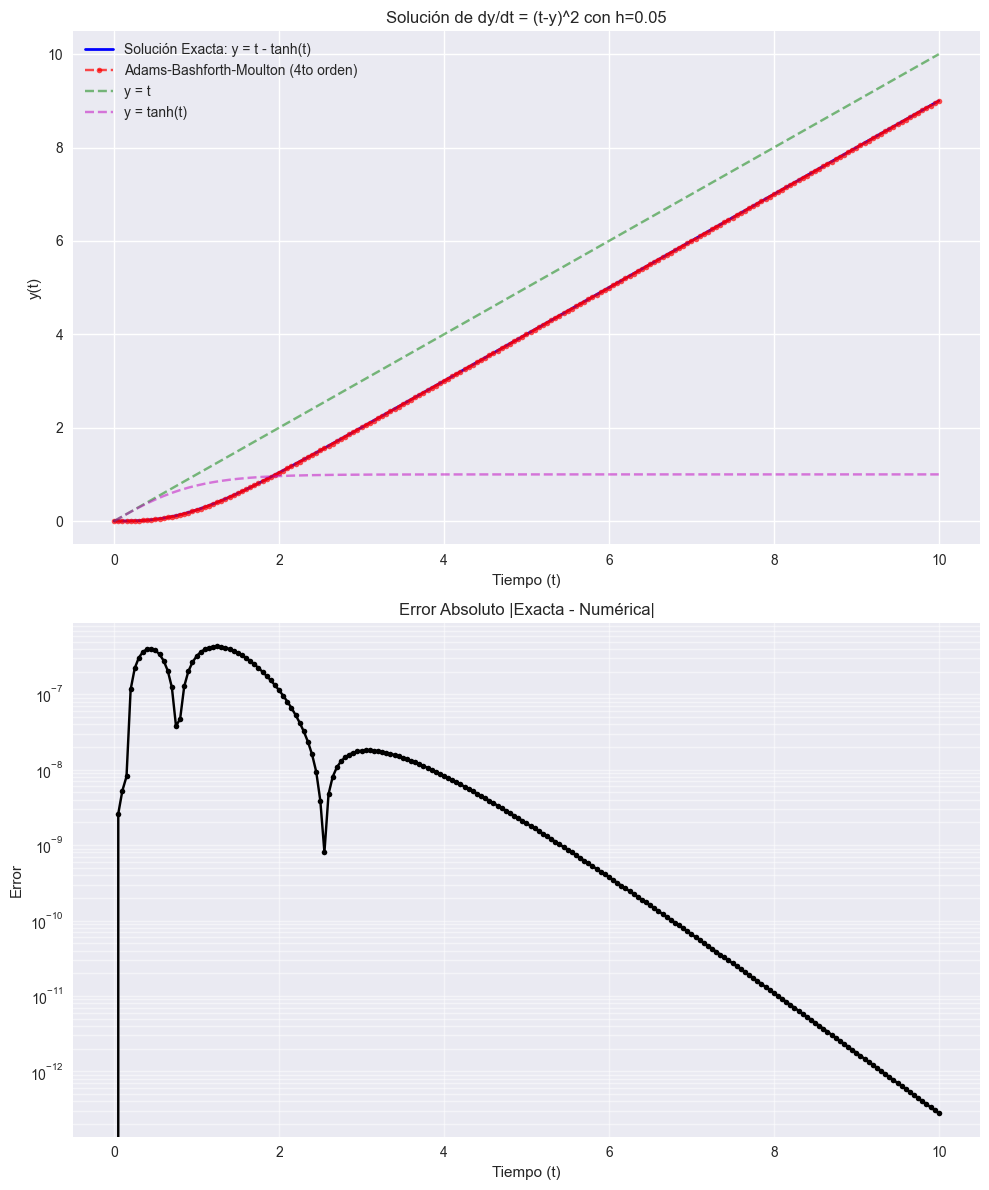

Error final en t=10.0: 2.77e-13


In [12]:
# Parámetros de simulación
t0 = 0.0
tf = 10.0
h = 0.05
y0 = 0.0

# Ejecutar el método numérico
t_num, y_num = adams_bashforth_moulton_4(f, t0, tf, y0, h)

# Calcular solución exacta para comparación
y_exact = solucion_exacta(t_num)

# Calcular error absoluto
error_abs = np.abs(y_exact - y_num)

# --- VISUALIZACIÓN ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Gráfico 1: Comparación
ax1.plot(t_num, y_exact, 'b-', label='Solución Exacta: y = t - tanh(t)', linewidth=2)
ax1.plot(t_num, y_num, 'r--o', label='Adams-Bashforth-Moulton (4to orden)', markersize=4, alpha=0.7)

# Componentes de la solución
ax1.plot(t_num, t_num, 'g--', label='y = t', alpha=0.5)
ax1.plot(t_num, np.tanh(t_num), 'm--', label='y = tanh(t)', alpha=0.5)

ax1.set_title(f'Solución de dy/dt = (t-y)^2 con h={h}')
ax1.set_xlabel('Tiempo (t)')
ax1.set_ylabel('y(t)')
ax1.legend()
ax1.grid(True)

# Gráfico 2: Error Absoluto
ax2.plot(t_num, error_abs, 'k-o', markersize=4)
ax2.set_title('Error Absoluto |Exacta - Numérica|')
ax2.set_xlabel('Tiempo (t)')
ax2.set_ylabel('Error')
ax2.set_yscale('log') # Escala logarítmica para apreciar mejor el orden de magnitud
ax2.grid(True, which="both", ls="-", alpha=0.5)

plt.tight_layout()
plt.show()

# Imprimir algunos valores finales para referencia
print(f"Error final en t={tf}: {error_abs[-1]:.2e}")

# 5. Conclusión

Al analizar los resultados obtenidos, podemos observar que el método de **Adams-Bashforth-Moulton de 4to orden** proporciona una aproximación excelente a la solución exacta.

*   **Precisión:** El gráfico de error absoluto muestra que el error se mantiene en órdenes de magnitud muy bajos (típicamente alrededor de $10^{-6}$ o $10^{-7}$ para un paso de $h=0.1$). Esto confirma la alta precisión esperada de un método de cuarto orden ($O(h^4)$).
*   **Estabilidad:** La solución numérica sigue fielmente la curva de la solución exacta sin mostrar oscilaciones espurias significativas, lo cual es característico de la estabilidad mejorada que aporta el paso corrector (Adams-Moulton) frente a usar solo un predictor explícito.
*   **Eficiencia:** Una vez superada la fase de arranque (que requiere 4 evaluaciones de función por paso con RK4), el método ABM4 es muy eficiente, requiriendo solo 2 evaluaciones de función por paso (una para el predictor y otra para el corrector), en comparación con las 4 que requeriría mantener RK4 durante todo el intervalo.